In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from prml.utils.datasets import load_mnist,load_iris

# PCA

In [2]:
class PCA():
    """PCA

    Attributes:
        X_mean (1-D array): mean of data
        weight (2-D array): proj matrix 
        importance (1-D array): contirbution of ratio

    """
    def __init__(self):
        pass
    
    def fit(self,X):
        """fit 

        Args:
            X (2-D array): shape = (N_samples,N_dim), data

        """

        N = X.shape[0]
        X_mean = X.mean(axis = 0) 
        S = (X - X_mean).T@(X - X_mean)/N 
        eig_val,eig_vec = np.linalg.eigh(S)
        eig_val,eig_vec = np.real(eig_val),np.real(eig_vec.real)
        idx = np.argsort(eig_val)[::-1]
        eig_val,eig_vec = eig_val[idx],eig_vec[:,idx]

        self.X_mean = X_mean 
        self.importance = eig_val/eig_val.sum()
        self.weight = eig_vec
    
    def transform(self,X,M,return_importance=False,whitening=False):
        """transform

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, if M > N_dim, M = N_dim 
            return_importance (bool): return importance or not
            whitening (bool): if whitening or not
        
        Retunrs:
            X_proj (2-D array): shape = (N_samples,M), projected data
            impotance_rate (float): how important X_proj is

        """
        if whitening:
            return (X-self.X_mean)@self.weight[:,:M]/np.sqrt(self.importance[:M])
        elif return_importance:
            return X@self.weight[:,:M],self.importance[:M].sum()
        else:
            return X@self.weight[:,:M]

    def fit_transform(self,X,M,return_importance=False,whitening=False):
        """fit_transform

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, if M > N_dim, M = N_dim 
            return_importance (bool): return importance or not
            whitening (bool): if whitening or not
        
        Retunrs:
            X_proj (2-D array): shape = (N_samples,M), projected data
            impotance_rate (float): how important X_proj is

        """
        self.fit(X)
        return self.transform(X,M,return_importance,whitening)

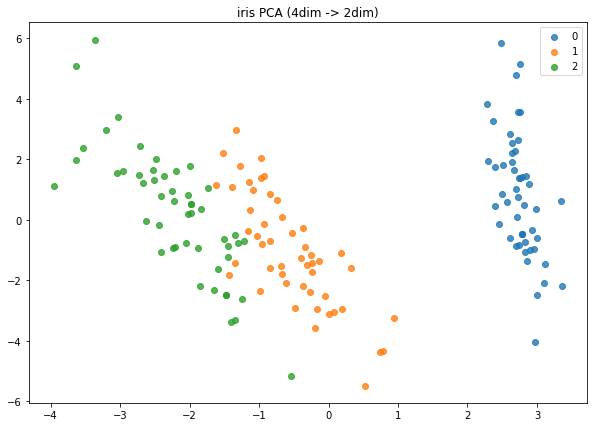

In [3]:
X,y = load_iris()
pca = PCA()
X_proj = pca.fit_transform(X,2,whitening=True)

fig,axes = plt.subplots(1,1,figsize=(10,7))
for idx,label in enumerate(np.unique(y)):
    axes.scatter(x=X_proj[y == label,0],
                y=X_proj[y == label,1],
                alpha=0.8,
                label=label)
axes.set_title("iris PCA (4dim -> 2dim)")
plt.legend()
plt.show()

### mnist image compression

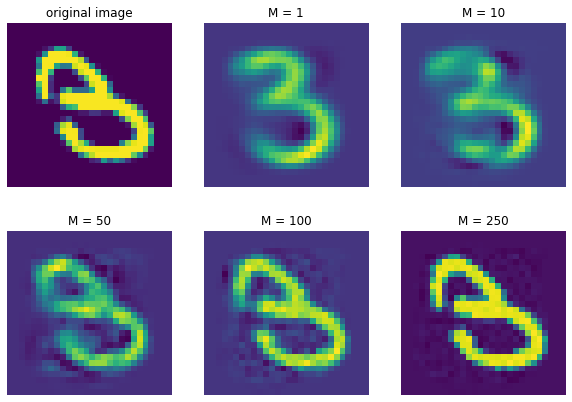

In [4]:
X,y  = load_mnist([3])
X = X[:600].reshape(-1,28*28)
X_mean = X.mean(axis=0)

pca = PCA() 
pca.fit(X)
img = X[0]
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(231)
ax.imshow(img.reshape(28,28))
ax.set_title("original image")
ax.axis("off")

img = img.ravel()
weight = pca.weight
approximate = np.dot(weight.T,img - X_mean)*weight
for n,M in enumerate([1,10,50,100,250]):
    ax = fig.add_subplot(int(f"23{n+2}"))
    img_proj = X_mean + np.sum(approximate[:,:M],axis = 1)
    i,j = (n+1)//2,(n+1)%3
    ax.imshow(img_proj.reshape(28,28))
    ax.set_title(f"M = {M}")
    ax.axis("off")

plt.show()

# ProbabilisticPCA

In [5]:
class ProbabilisticPCA():
    """ProbabilisticPCA

    find parameter by maximum likelihood method, O(D^3)

    Attributes:
        D (int): original dim of data
        mu (1-D array): mean of data
        W (2-D array): param of density of data
        sigma (float): param of density of data
        U (2-D array): eigen vectors of covariance matrix of data
        lamda (1-D array): eigen values of covariance matrix of data

    """
    def __init__(self) -> None:
        pass

    def fit(self,X):
        """

        Args:
            X (2-D array): shape = (N_samples,N_dim), data

        """

        N = X.shape[0]
        X_mean = X.mean(axis = 0) 
        S = (X - X_mean).T@(X - X_mean)/N 
        eig_val,eig_vec = np.linalg.eigh(S)
        eig_val,eig_vec = np.real(eig_val),np.real(eig_vec.real)
        idx = np.argsort(eig_val)[::-1]
        eig_val,eig_vec = eig_val[idx],eig_vec[:,idx]

        self.D = X.shape[1]
        self.mu = X_mean
        self.U = eig_vec 
        self.lamda = eig_val 

    def transform(self,X,M):
        """transform 

        after this method is called, attribute W,sigma can be used

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, M is less than X.shape[1]
        
        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data

        """
        if self.D == M:
            raise ValueError("M is less than X.shape[1]")
        
        sigma = np.mean(self.lamda[M:])
        W = self.U[:,:M]@(np.diag((self.lamda[:M] - sigma)**0.5))
        
        Mat = W.T@W + sigma*np.eye(M)
        proj_weight = W@np.linalg.inv(Mat) # x -> z
        return (X - self.mu)@proj_weight

    def fit_transform(self,X,M):
        """fit_transform

        after this method is called, attribute W,sigma can be used

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, M is less than X.shape[1]
        
        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data

        """
        self.fit(X)
        return self.transform(X,M)

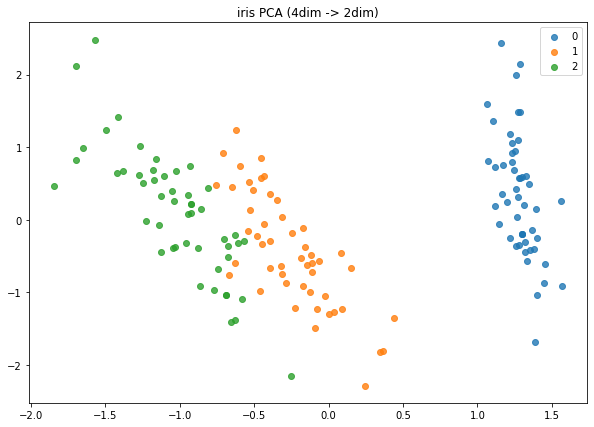

In [6]:
X,y = load_iris()
ppca = ProbabilisticPCA()
X_proj = ppca.fit_transform(X,2)

fig,axes = plt.subplots(1,1,figsize=(10,7))
for idx,label in enumerate(np.unique(y)):
    axes.scatter(x=X_proj[y == label,0],
                y=X_proj[y == label,1],
                alpha=0.8,
                label=label)
axes.set_title("iris PCA (4dim -> 2dim)")
plt.legend()
plt.show()

# Probablistic PCA 

In [7]:
class ProbabilisticPCAbyEM():
    """ProbabilisticPCAbyEM

    Attributes:
        M (int): dimension of latent variables
        mu (1-D array): mean of data
        W (2-D array): param of density of data
        sigma (float): param of density of data

    """
    def __init__(self,max_iter=100,threshold=1e-5) -> None:
        """

        Args:
            max_iter (int): maximum iteration 
            threshold (float): threshold

        """
        self.max_iter = max_iter 
        self.threshold = threshold 

    def fit(self,X,M,find_M=False,alpha_limit=10):
        """

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): dimension of latent variables 
            find_M (bool): if appropriate M will be found or not, if this is True, appropriate_M <= M
            alpha_limit (float): if alpha is more than this, this component is removed

        """

        N = X.shape[0]
        D = X.shape[1]

        # init param 
        self.mu = X.mean(axis = 0)
        W = np.random.randn(D,M)
        sigma = np.random.rand() + 1e-1
        if find_M:
            alpha = np.random.rand(M) + 1e-1

        Y = X - self.mu 
        Ysum = np.sum(Y**2)

        for _ in range(self.max_iter):

            # E step 
            Mat = W.T@W + sigma*np.eye(M)
            Minv = np.linalg.inv(Mat) 
            E_z = Y@W@Minv 
            E_zz = sigma*Minv + E_z.reshape(-1,M,1)@E_z.reshape(-1,1,M)

            # M step 
            if find_M:
                W_new = Y.T@E_z@np.linalg.inv(E_zz.sum(axis = 0) + sigma*np.diag(alpha)) 
            else:
                W_new = Y.T@E_z@np.linalg.inv(E_zz.sum(axis = 0))
            sigma_new = (Ysum - 2*np.diag(E_z@W_new.T@Y.T).sum() + np.diag(np.sum(E_zz@W_new.T@W_new,axis=0)).sum())/(N*D)

            diff = ((sigma_new - sigma)**2 + np.mean((W_new - W)**2)) ** 0.5
            if diff < self.threshold:
                W = W_new 
                sigma = sigma_new 
                break 

            W = W_new 
            sigma = sigma_new 

            if find_M:
                alpha = D/np.diag(W.T@W)
                idx = alpha < alpha_limit
                alpha = alpha[idx]
                W = W[:,idx]
                M = idx.astype("int").sum()
        
        self.M = M 
        self.W = W
        self.sigma = sigma 

    def transform(self,X):
        """transform 

        Args:
            X (2-D array): shape = (N_samples,N_dim), data

        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data
        
        Note:
            unlike other method you should choose M when you call `fit()`
        """

 
        Mat = self.W.T@self.W + self.sigma*np.eye(self.M)
        proj_weight = self.W@np.linalg.inv(Mat) # x -> z
        return (X - self.mu)@proj_weight

    def fit_transform(self,X,M,find_M=False,alpha_limit=10):
        """fit_transform

        after this method is called, attribute W,sigma can be used

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, M is less than X.shape[1]
            find_M (bool): if appropriate M will be found or not, if this is True, appropriate_M <= M
            alpha_limit (float): if alpha is more than this, this component is removed
        
        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data

        """
        self.fit(X,M,find_M,alpha_limit)
        return self.transform(X)

you can find appropriate `M` by EM algorhithm

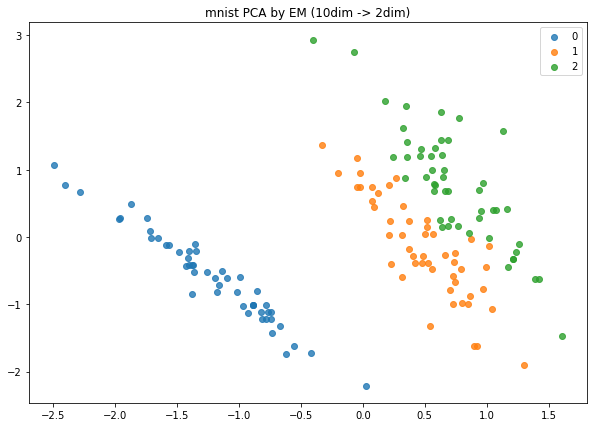

In [8]:
X,y = load_iris()
em = ProbabilisticPCAbyEM(max_iter=1000)
X_proj = em.fit_transform(X,4,find_M=True)
M = X_proj.shape[1]

if M == 1:
    fig,ax = plt.subplots(1,1,figsize=(10,7))
    for idx,label in enumerate(np.unique(y)):
        ax.hist(x=X_proj[y == label,0],
                alpha=0.8,
                label=label)
    ax.set_title("iris PCA by EM (4dim -> 1dim)")
    plt.legend()
    plt.show()

elif M == 2:
    fig,axes = plt.subplots(1,1,figsize=(10,7))
    for idx,label in enumerate(np.unique(y)):
        axes.scatter(x=X_proj[y == label,0],
                    y=X_proj[y == label,1],
                    alpha=0.8,
                    label=label)
    axes.set_title("mnist PCA by EM (10dim -> 2dim)")
    plt.legend()
    plt.show()

else:
    print(f"M = {M} >= 3 ...")

# Factor Analysis

In [9]:

class FactorAnalysis():
    """FactorAnalysis

    """
    def __init__(self,max_iter=100,threshold=1e-5) -> None:
        """

        Args:
            max_iter (int): maximum iteration 
            threshold (float): threshold

        """
        self.max_iter = max_iter 
        self.threshold = threshold 

    def fit(self,X,M):
        """fit 
        """
        
        N = X.shape[0]
        D = X.shape[1]

        self.mu = X.mean(axis = 0)
        W = np.random.randn(D,M)
        Sigma = np.random.rand(D) + 1e-1

        Y = X - self.mu 
        S = Y.T@Y/N 

        for _ in range(self.max_iter):

            # E step 
            G = np.linalg.inv(np.eye(M) + (W.T/Sigma)@W) 
            E_z = Y/Sigma@W@G.T 
            E_zz = G + E_z.reshape(-1,M,1)@E_z.reshape(-1,1,M) 

            # M step 
            W_new = Y.T@E_z@np.linalg.inv(E_zz.sum(axis = 0)) 
            Sigma_new = np.diag(S - W_new@E_z.T@Y/N)

            diff = (np.mean((Sigma_new - Sigma)**2) + np.mean((W_new - W)**2))**0.5
            if diff < self.threshold:
                W = W_new 
                Sigma = Sigma_new 
                break 

            W = W_new 
            Sigma = Sigma_new 
        
        self.W = W
        self.Sigma = Sigma 
        self.G = G = np.linalg.inv(np.eye(M) + (W.T/Sigma)@W)

    def transform(self,X):
        """transform 

        Args:
            X (2-D array): shape = (N_samples,N_dim), data

        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data
        
        """
 
        return (X - self.mu)/self.Sigma@self.W@self.G.T

    def fit_transform(self,X,M):
        """fit_transform

        after this method is called, attribute W,sigma can be used

        Args:
            X (2-D array): shape = (N_samples,N_dim), data
            M (int): number of principal component, M is less than X.shape[1]

        Returns:
            X_proj (2-D array): shape = (N_samples,M), projected data

        """
        self.fit(X,M)
        return self.transform(X)

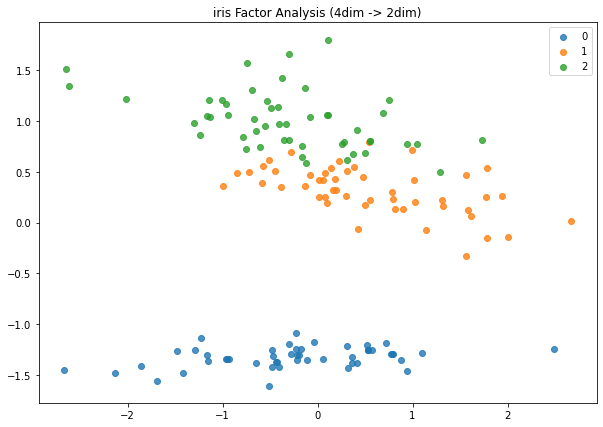

In [11]:
X,y = load_iris() 
fa = FactorAnalysis() 
X_proj = fa.fit_transform(X,M=2)

fig,axes = plt.subplots(1,1,figsize=(10,7))
for idx,label in enumerate(np.unique(y)):
    axes.scatter(x=X_proj[y == label,0],
                y=X_proj[y == label,1],
                alpha=0.8,
                label=label)
axes.set_title("iris Factor Analysis (4dim -> 2dim)")
plt.legend()
plt.show()